In [10]:
import numpy as np
import pandas as pd
import json

In [11]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

In [12]:
SYMBOLS = ['BANANAS','PEARLS']
LOG_DIR = 'round1_logs/'

In [13]:
p = 'PEARLS'
b = 'BANANAS'

# DATA LOADING

In [612]:
def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

def load_hist_quote_data(files):
    md = [pd.read_csv(f,sep=';') for f in files]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['profit_and_loss'], inplace=True)
    rename_columns = {'product':'symbol', 'bid_price_1': 'bid', 'ask_price_1': 'ask', 
                      'bid_volume_1':'bid_sz', 'ask_volume_1': 'ask_sz', 
                      'bid_price_2':'bid_2','bid_volume_2':'bid_sz_2','ask_price_2':'ask_2','ask_volume_2':'ask_sz_2',
                      'bid_price_3':'bid_3','bid_volume_3':'bid_sz_3','ask_price_3':'ask_3','ask_volume_3':'ask_sz_3'}
    md.rename(columns=rename_columns, inplace=True)
    for i in [4, 5]:
        for col in ['bid','ask']:
            md[f'{col}_{i}'] = np.nan
            md[f'{col}_sz_{i}'] = np.nan

    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def load_hist_trade_data(files,hist_days):
    md = [pd.read_csv(f,sep=';') for f in files]
    for i in range(len(hist_days)):
        md[i]['day'] = hist_days[i]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['buyer', 'seller'], inplace=True)
    md = md[md.price > 0].copy()
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def combine_hist_quote_trades(hist_quotes, hist_trades):
    """ Join data frames together
    """
    for sym in SYMBOLS:
        quotes = hist_quotes[sym]
        trades = hist_trades[sym]
        # Join quote data to trades
        trades = trades.merge(quotes, how='left', on=['symbol','day','timestamp'])

        # Summarize state by state trade data
        trades['notional'] = trades['price']*trades['quantity']
        trades_grp = trades.groupby(['symbol','day','timestamp']).agg({
            'quantity':'sum', 'notional':'sum',})
            # 'buy_vol':'sum', 'sell_vol':'sum','grey_vol':'sum'})
        trades_grp['vwap'] = trades_grp['notional']/trades_grp['quantity']
        trades_grp['trades'] = trades.groupby(['symbol','day','timestamp']).size()
        trades_grp = trades_grp.rename(columns={'quantity':'volume'})
        
        # Join trade data to quote
        quotes = quotes.merge(trades_grp.reset_index(), how='left')
        for col in ['volume', 'notional','trades']:
            quotes[col].fillna(0, inplace=True)
        quotes.loc[quotes.vwap.isna(), 'vwap'] = quotes.loc[quotes.vwap.isna(), 'mid_price']
        
        # Update
        hist_quotes[sym] = quotes
        hist_trades[sym] = trades
    
    return hist_quotes, hist_trades

def load_hist_data(quote_files, trade_files, hist_days):
    hist_quotes = load_hist_quote_data(quote_files)
    hist_trades = load_hist_trade_data(trade_files, hist_days)
    
    hist_quotes, hist_trades = combine_hist_quote_trades(hist_quotes, hist_trades)
    return hist_quotes, hist_trades

In [605]:
def quote_levels_feature(quote):
    quote['bid_levels'] = 1
    quote['ask_levels'] = 1
    
    for i in range(2,6):
        quote.loc[quote[f'bid_{i}'].notna(), 'bid_levels'] += 1
        quote.loc[quote[f'ask_{i}'].notna(), 'ask_levels'] += 1
    
    return

def quote_weighted_px_full(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask
    size = quote.bid_sz + quote.ask_sz
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

def quote_weighted_px_full_trade_notional(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask + quote.notional
    size = quote.bid_sz + quote.ask_sz + quote.volume
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

def quote_weighted_px_skip_top(quote, levels=5):
    notional, size = 0, 0
    
    if quote['bid_sz'] >= 5:
        notional += quote.bid_sz*quote.bid
        size += quote.bid_sz
    if quote['ask_sz'] >= 5:
        notional += quote.ask_sz*quote.ask
        size += quote.ask_sz

    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

In [689]:
MOVING_WINDOW_TIMES = [5, 10, 25, 50]
HIST_PX_TIMES = [1, 5, 10, 20, 30, 50]
FUTURE_TIMES = [1, 5, 10, 25, 50, 100]

def quote_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    if 'bid_levels' not in md.columns:
        quote_levels_feature(md)
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
    for t in MOVING_WINDOW_TIMES:
        md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
        md[f'mid_px_mavg{t}_norm'] = md[f'mid_px_mavg{t}']/md['mid_price']
        md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['fair_v1'] = md.apply(quote_weighted_px_full, axis=1)
    md['fair_v2'] = md.apply(quote_weighted_px_full, axis=1, args=[2])
    md['fair_v3'] = md['vwap']
    md['fair_v4'] = md.apply(quote_weighted_px_full_trade_notional, axis=1)
    
    for t in HIST_PX_TIMES:
        # Price move since the past
        md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
        md[f'bid_move_{t}'] = md.bid-md.bid.shift(t)
        md[f'ask_move_{t}'] = md.ask-md.ask.shift(t)
        
        md[f'px_move_{t}'].fillna(0, inplace=True)
        md[f'bid_move_{t}'].fillna(0, inplace=True)
        md[f'ask_move_{t}'].fillna(0, inplace=True)
        
        md[f'px_move_{t}_norm'] = md[f'px_move_{t}']/md['mid_price']
        
        # log return
        md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
        md[f'log_return_{t}'].fillna(1, inplace=True)
    # Volume    
    for t in MOVING_WINDOW_TIMES:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()
        
    md = md.copy()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    
    ############# Future
    # Future prices
    for t in FUTURE_TIMES:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.ask
    for t in FUTURE_TIMES:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    md['fvolume'] = md['volume'].shift(-1)
    for t in MOVING_WINDOW_TIMES:
        md[f'fvolume_{t}'] = md[f'volume_{t}'].shift(-t)
    md = md.copy()
        
    # Features
    md['total_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].sum(axis=1)
    md['max_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].max(axis=1)
    md['total_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].sum(axis=1)
    md['max_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].max(axis=1)
    
    md['bid_sz_mavg'] = md['bid_sz'].cumsum()/(1+md['timestamp']/100)
    md['ask_sz_mavg'] = md['ask_sz'].cumsum()/(1+md['timestamp']/100)
       
    for v in [1, 2, 3, 4]:
        md[f'dist_fair_v{v}'] = md[f'fair_v{v}']-md['mid_price']
        md[f'dist_fair_v{v}_norm'] = md[f'dist_fair_v{v}']/md['mid_price']
        
        md[f'dist_fair_v{v}_bid'] = md[f'fair_v{v}']-md['bid'] # expected to be positive
        md[f'dist_fair_v{v}_ask'] = md[f'fair_v{v}']-md['ask'] # expected to be negative
        for t in HIST_PX_TIMES:
            md[f'fair_v{v}_move_{t}'] = md[f'fair_v{v}']-md[f'fair_v{v}'].shift(t)
            
    
    md['bid_improve'] = md['bid'] > md['bid'].shift(1)
    md['bid_revert'] = md['bid'] < md['bid'].shift(1)
    md['ask_improve'] = md['ask'] < md['ask'].shift(1)
    md['ask_revert'] = md['ask'] > md['ask'].shift(1)
    
    return md

In [160]:
def hist_data_summary(hist_quotes, hist_trades):
    for sym in SYMBOLS:
        print(sym)
        quote = hist_quotes[sym]
        quote_summary = quote.agg({
            'spread':['mean','std'], 'mid_price': ['mean','std'], 
            'volume':['sum', 'mean'], 'trades':['sum', 'mean'],
            'bid_sz': 'mean', 'ask_sz':'mean', 
            'bid_levels':'mean', 'ask_levels':'mean',
            'bid_sz_2':'mean', 'ask_sz_2':'mean',
            'bid_sz_3':'mean', 'ask_sz_3':'mean',
        }).round(2)
        display(quote_summary)

## Load

In [690]:
data_dir = 'hist_data/island-data-bottle-round-1/'
hist_days = [-2, -1, 0]
quote_files = [f'{data_dir}prices_round_1_day_{i}.csv' for i in hist_days]
trade_files = [f'{data_dir}trades_round_1_day_{i}_nn.csv' for i in hist_days]

hist_quotes, hist_trades = load_hist_data(quote_files, trade_files, hist_days)
for sym in SYMBOLS:
    hist_quotes[sym] = quote_preprocess(hist_quotes[sym])

In [162]:
hist_data_summary(hist_quotes, hist_trades)

BANANAS


,spread,mid_price,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,5.29,4929.88,0.78,0.29,17.55,17.98,1.41,1.4,23.27,22.43,24.5,24.28
std,1.90,38.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,23545.00,8551.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


PEARLS


,spread,mid_price,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,6.77,10000.0,0.51,0.24,8.22,8.21,1.92,1.92,19.71,19.67,23.1,23.11
std,2.48,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,15227.00,7235.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# TRADING LOG LOADING

In [671]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})")
    # orders_depth_regex = re.compile(r"(\d+) ORDER_DEPTHS (\{.*\})")
    # market_trades_regex = re.compile(r"(\d+) MARKET_TRADES (\{.*\})")
    # own_trades_regex = re.compile(r"(\d+) OWN_TRADES (\{.*\})")
    # position_regex = re.compile(r"(\d+) POSITION (\{.*\})")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")
    empty_regex = re.compile(r"(\d+) \$")
    
    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
            match = empty_regex.match(l)
            if match:
                trading_states.append(match.group(1))
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": -1, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            
    positions = pd.DataFrame(positions)
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    for p in SYMBOLS:
        if p not in pos:
            positions.append({"timestamp": state['timestamp'], "symbol": p, "position": 0})
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100:
                market_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return

def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)):
        # Highest to lowest
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(5, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))):
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(5, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    order_depths['mid_price'] = (order_depths['bid']+order_depths['ask'])/2
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz', 'mid_price']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """ 
    # Side refers to side of algo
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    return df

def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    Experimental - NOT SURE IF THIS IS GOING TO BE HELPFUL
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(ask_dist - bid_dist)
    return

def combine_quote_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    # trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
    # trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
    # trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['vwap'] = trades_grouped['notional']/trades_grouped['quantity']
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), how='left')
    for col in ['volume', 'notional','trades']:
        quote[col].fillna(0, inplace=True)
    
    quote.loc[quote.vwap.isna(), 'vwap'] = quote.loc[quote.vwap.isna(), 'mid_price']
    return quote

def combine_quote_algo_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), on=['symbol','timestamp'], how='left', suffixes=('','_algo'))
    
    for col in ['volume_algo', 'notional_algo', 'trades_algo']:
        quote[col].fillna(0, inplace=True)
    
    return quote

def fill_active(x):
    if x['side'] == 1:
        # Buy
        return x['price'] >= x['ask']
    else:
        return x['price'] <= x['bid']

def combine_orders_fills(orders, fills):
    """ Combine orders sent with fills that the order got in the market
    """
    if orders.empty:
        return orders
    fills['active'] = fills.apply(fill_active, axis=1)
    fills['active_qty'] = fills['active']*fills['quantity']
    fills['passive_qty'] = (~fills['active'])*fills['quantity']

    fill_data = fills.groupby(['symbol','timestamp','price', 'side'])[['quantity','active_qty','passive_qty']].sum()
    fill_data.reset_index(inplace=True)
    fill_data.rename(columns={'quantity': 'fill_qty'}, inplace=True)
    orders = orders.merge(fill_data, how='left', on=['symbol','timestamp','price','side'])
    for col in ['fill_qty','active_qty','passive_qty']:
        orders[col].fillna(0, inplace=True)
    orders['fill_pct'] = np.abs(orders['fill_qty']/orders['quantity'])
    
    return orders

# PnL, Position, Volume Traded, Notional Traded, VWAP
def trading_performance(positions, own_trades, quote):
    positions = positions.merge(quote[['timestamp','symbol','mid_price']], on=['symbol','timestamp']) # Add mid price
    own_trades['trades'] = 1
    own_trades['notional'] = own_trades['price']*own_trades['quantity']
    own_trades.rename(columns={'quantity':'qty'},inplace=True)
    vol_cols = []
    for col in ['qty','notional','trades']:
        own_trades[f'buy_{col}'] = own_trades[col]
        own_trades[f'sell_{col}'] = own_trades[col]
        own_trades.loc[own_trades['side'] == -1, f'buy_{col}'] = 0
        own_trades.loc[own_trades['side'] == 1, f'sell_{col}'] = 0
        vol_cols += [col, f'buy_{col}',f'sell_{col}']
    own_trades_g = own_trades.groupby(['symbol','timestamp'])[vol_cols].sum()

    positions = positions.merge(own_trades_g.reset_index(), how='left', on=['symbol','timestamp'])
    for col in vol_cols:
        positions[col].fillna(0, inplace=True)
        positions[f'total_{col}'] = positions.groupby(['symbol'])[col].cumsum()
    positions['pnl'] = (positions['total_sell_notional']-positions['total_buy_notional']) \
            - positions['mid_price']*(positions['total_sell_qty']-positions['total_buy_qty'])

    positions = positions.copy()
    return positions

def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    orders = process_sent_orders_json(sent_orders)
    
    # Joining actions to state
    market_trades = market_trades.merge(quote, how='left', on=['symbol','timestamp',])
    augment_trade_data(market_trades)
    
    own_trades = own_trades.merge(quote, how='left', on=['symbol','timestamp','symbol'])
    orders = orders.merge(quote, how='left', on=['symbol','timestamp'])
    orders = combine_orders_fills(orders, own_trades)
    
    quote = combine_quote_trades(quote, market_trades.copy())
    quote = combine_quote_algo_trades(quote, own_trades.copy())

    order_depths = combine_quote_trades(order_depths, market_trades.copy())
    order_depths = combine_quote_algo_trades(order_depths, own_trades.copy())
    
    positions = trading_performance(positions, own_trades.copy(), quote) 
    
    dfs = {}
    dfs['orders'] = orders
    dfs['positions'] = positions
    dfs['order_depths'] = order_depths
    dfs['quote'] = quote
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    
    if by_symbol:
        for table in dfs:
            dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs

In [206]:
fig_size = (6,3)

def plot_intraday(dfs, col):
    f, ax = plt.subplots(figsize=fig_size)
    for product in dfs:
        ax.plot("timestamp", col, data=dfs[product], label=product)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.legend()
    return

def plot_quote(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", "bid", data=md, color="red")
    ax.plot("timestamp", "ask", data=md, color="blue")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (Seashells)")
    ax.set_title(sym)
    return

def trading_simulation_summary(dfs):
    total_pnl = 0
    for sym in SYMBOLS:
        trade_perf = dfs['positions'][sym].iloc[-1]
        pnl = trade_perf['pnl']
        total_pnl += pnl
        market_volume = dfs['market_trades'][sym]['quantity'].sum()
        trade_count = trade_perf['total_trades']
        trade_volume = trade_perf['total_qty']
        vol_per_step = dfs['positions'][sym]['qty'].mean()

        print("""{}: PnL={} | Trades={} | MarketVol={} | Volume Filled={} | POV={:.2} | Shares/Step={:.3} | PnL/Share={:.4}""".format(sym, \
            pnl, trade_count, market_volume, trade_volume,trade_volume/(market_volume+trade_volume), vol_per_step, pnl/trade_volume))
    print("Total PnL={}".format(total_pnl))
    plot_intraday(dfs['positions'], 'pnl')
    plot_intraday(dfs['positions'], 'position')

## Load

BANANAS: PnL=1674.5 | Trades=283.0 | MarketVol=379 | Volume Filled=975.0 | POV=0.72 | Shares/Step=0.976 | PnL/Share=1.717
PEARLS: PnL=1617.0 | Trades=302.0 | MarketVol=324 | Volume Filled=846.0 | POV=0.72 | Shares/Step=0.847 | PnL/Share=1.911
Total PnL=3291.5


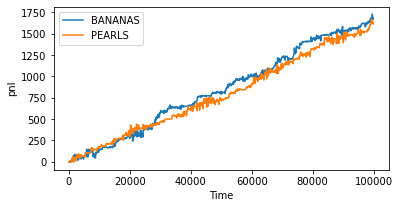

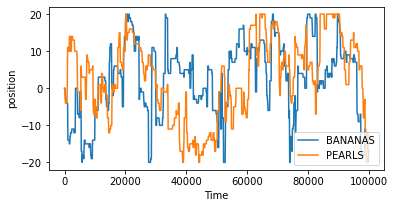

In [870]:
file_name = "afda66b9-a91a-4818-a42a-b14bb3cd8466"
file_name = "912e6fee-08ad-4f9a-9ca5-4539b97dafab"

file_name = "e1bfa845-e399-4bc4-9944-03088d04c12a"
file_name = "619c60cc-b190-498c-82a2-99039d6483e1"
file_name = "8bbf5a70-4c89-4f8a-93c2-dda55e6277f9"
file_name = "0d5d383a-7abb-441e-8749-19193ea0b8cb"
file_name = "6cc79787-7b94-47ad-a468-607a6e3249c3"


log_file = LOG_DIR + file_name + '.log'
dfs = load_data_from_log(log_file, True)
trading_simulation_summary(dfs)

In [707]:
test = quote_preprocess(dfs['order_depths'][p])

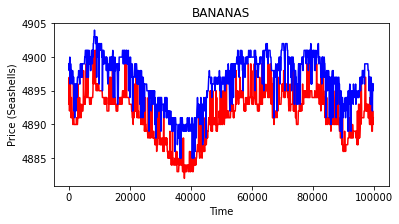

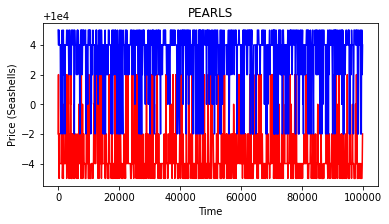

In [251]:
for s in SYMBOLS:
    plot_quote(dfs['quote'][s], s)

In [133]:
# Ensure that orders are not crossing
orders = dfs['orders'][b]
buy_orders = orders.loc[orders.side == 1].copy()
sell_orders = orders.loc[orders.side == -1].copy()

orders_sent = buy_orders.merge(sell_orders[['symbol','timestamp','price','quantity','fill_qty','note']], on=['symbol','timestamp'], suffixes=("_buy","_sell"))
orders_sent.loc[orders_sent['price_buy'] >= orders_sent['price_sell']]

,note_buy,price_buy,quantity_buy,side,symbol,timestamp,bid,ask,bid_sz,ask_sz,mid_price,fill_qty_buy,active_qty,passive_qty,fill_pct,price_sell,quantity_sell,fill_qty_sell,note_sell


# Algo MM Analysis
- Analyzing the spread of the orders that the algo is sending.
- When is the size of the spread when the algo is getting hit?

In [276]:
def algo_spread(x):
    bid = np.fmax(x['price_algo_buy'], x['bid'])
    ask = np.fmin(x['price_algo_sell'], x['ask'])
    return ask-bid

def get_algo_market(orders, quote):
    buy_orders = orders.loc[orders.side == 1].copy()
    sell_orders = orders.loc[orders.side == -1].copy()

    buy_spread = buy_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    buy_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='last') # keep most aggressive
    sell_spread = sell_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    sell_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='first')
    
    algo_market = buy_spread.merge(sell_spread, how='outer', on=['symbol','timestamp'], suffixes=['_algo_buy','_algo_sell'])
    algo_market.sort_values('timestamp',inplace=True)
    algo_market = algo_market.merge(quote, how='left', on=['symbol','timestamp'])
    algo_market['spread'] = algo_market['ask'] - algo_market['bid']
    algo_market['algo_spread'] = algo_market.apply(algo_spread, axis=1)
    
    return algo_market

In [661]:
orders = dfs['orders'][b]
quote = dfs['quote'][b]
algo_market = get_algo_market(orders, quote)

In [279]:
# negative spread refers to when the algo crossed
algo_market[['algo_spread']].value_counts()/len(algo_market)

algo_spread
 4.0           0.411411
 5.0           0.293293
 0.0           0.166166
 3.0           0.108108
 2.0           0.010010
 1.0           0.007007
-1.0           0.004004
dtype: float64

In [270]:
algo_market.head()

,symbol,timestamp,price_algo_buy,quantity_algo_buy,fill_qty_algo_buy,price_algo_sell,quantity_algo_sell,fill_qty_algo_sell,bid,ask,bid_sz,ask_sz,mid_price,volume,vwap,trades,volume_algo,trades_algo,spread,algo_spread
0,BANANAS,0,4894.0,20.0,0.0,4898.0,20.0,0.0,4893.0,4899.0,9,23,4896.0,0.0,4896.0,0.0,0.0,0.0,6.0,4.0
1,BANANAS,100,4894.0,20.0,0.0,4897.0,20.0,2.0,4897.0,4898.0,1,22,4897.5,0.0,4897.5,0.0,0.0,0.0,1.0,0.0
2,BANANAS,200,4893.0,21.0,0.0,4898.0,19.0,1.0,4892.0,4899.0,22,22,4895.5,0.0,4895.5,0.0,1.0,1.0,7.0,5.0
3,BANANAS,300,4896.0,22.0,0.0,4898.0,3.0,1.0,4898.0,4900.0,1,26,4899.0,0.0,4899.0,0.0,1.0,1.0,2.0,0.0
4,BANANAS,400,4895.0,23.0,0.0,4896.0,17.0,0.0,4894.0,4896.0,8,5,4895.0,0.0,4895.0,0.0,1.0,1.0,2.0,1.0


In [281]:
algo_market.loc[algo_market.volume > 0][['algo_spread']].value_counts().sort_index()/len(algo_market)

algo_spread
0.0            0.023023
1.0            0.003003
3.0            0.027027
4.0            0.076076
5.0            0.043043
dtype: float64

In [284]:
algo_market.loc[algo_market.volume_algo > 0][['algo_spread']].value_counts().sort_index()/len(algo_market)

algo_spread
0.0            0.033033
1.0            0.003003
2.0            0.002002
3.0            0.022022
4.0            0.110110
5.0            0.082082
dtype: float64

In [287]:
algo_market_cols = ['symbol', 'timestamp', 'price_algo_buy', 'price_algo_sell','algo_spread']

# Market Trade Analysis
- Trying to understand what causes algo to miss market trades

In [780]:
def order_analysis(orders):
    orders['px_bid_dist'] = orders['price'] - orders['bid']
    orders['px_ask_dist'] = orders['price'] - orders['ask']
    orders['filled'] = orders['fill_qty'] > 0
    
    for t in FUTURE_TIMES:
        orders[f'toxicity_{t}'] = orders['side']*(orders[f'fpx_{t}']+orders['mid_price']-orders['price'])
        orders[f'pnl_{t}'] = orders['fill_qty']*orders[f'toxicity_{t}']
        orders[f'fill_revert_{t}'] = np.sign(orders[f'pnl_{t}'])
        orders[f'spread_capture_{t}'] = orders[f'toxicity_{t}']/orders['spread']
    
    return

toxicity_labels, reversion_labels = [], []
for t in FUTURE_TIMES:
    toxicity_labels.append(f'toxicity_{t}')
    reversion_labels.append(f'fill_revert_{t}')

In [862]:
sym = p
market_trades = dfs['market_trades'][sym]
orders = dfs['orders'][sym]
quote = dfs['order_depths'][sym].copy()
algo_market = get_algo_market(orders, quote)

orders_cols = ['note', 'price', 'quantity', 'side', 'symbol', 'timestamp','fill_qty']
fills = orders.loc[orders.fill_qty > 0]
fills = fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
order_analysis(fills)
fills = fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])

buy_fills = fills.loc[fills.side == 1].copy()
sell_fills = fills.loc[fills.side == -1].copy()

missed_fills = orders[orders_cols].merge(market_trades, on=['symbol','timestamp'], suffixes=('_algo','_mkt'))
missed_fills = missed_fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
missed_fills = missed_fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])

missed_buy_fills = missed_fills.loc[(missed_fills.side_algo == 1) & (missed_fills.fair_v1 >= missed_fills.price_mkt)].copy()
missed_sell_fills = missed_fills.loc[(missed_fills.side_algo == -1) & (missed_fills.fair_v1 <= missed_fills.price_mkt)].copy()

In [863]:
total_fills = fills.groupby(['side'])['fill_qty'].sum()
fill_win = fills.groupby(['side','fill_revert_100','note'])['pnl_100'].sum()
fill_win = fill_win
fill_win.unstack()

note                   P0    P1  P1_2     P2     P3    P4    X_0  X_1
side fill_revert_100                                                 
-1   -1.0            -6.0   NaN   NaN   -0.5   -2.5   NaN  -64.0 -6.0
      0.0             NaN   0.0   NaN    0.0    0.0   NaN    0.0  NaN
      1.0             NaN  18.0   9.0   80.0  216.0  93.0  472.5  NaN
 1   -1.0             NaN   NaN  -2.5   -0.5   -0.5   NaN  -50.5  NaN
      0.0             0.0   NaN   NaN    0.0    NaN   NaN    0.0  NaN
      1.0             NaN  19.0   NaN  168.0  140.5  36.0  479.0  7.0

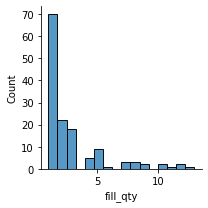

In [771]:
sns.displot(x='fill_qty', data=fills.loc[fills.note == 'P2'], height=3)

In [430]:
fills['spread_2'] = fills['mid_price'] - fills['bid_2']

In [368]:
fill_cols = ['note', 'price', 'quantity', 'fill_qty','side', 'timestamp', 'bid',
       'ask', 'bid_sz', 'ask_sz', 'mid_price','max_bid_sz','max_ask_sz','total_bid_sz','total_ask_sz', 'fair_v1', 'pnl_50']

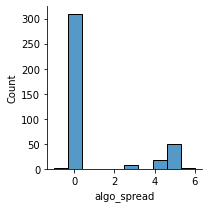

In [698]:
sns.displot(x='algo_spread', data=fills, height=3)

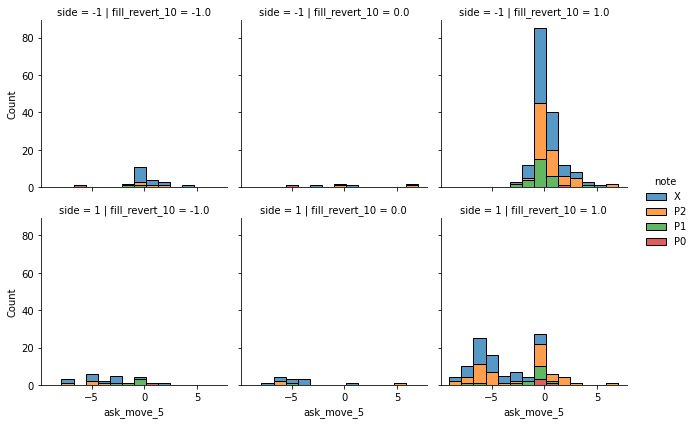

In [686]:
sns.displot(x='ask_move_5', data=fills, row='side', col='fill_revert_10', height=3, hue='note', multiple='stack')

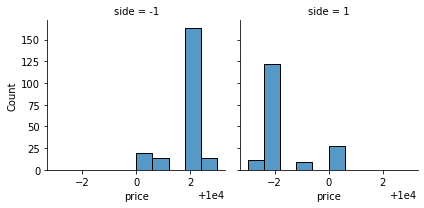

In [751]:
sns.displot(x='price', data=fills, height=3, col='side')

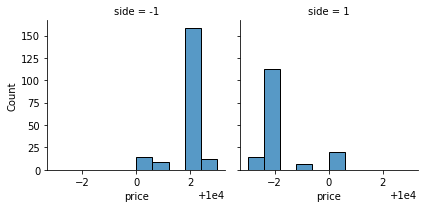

In [759]:
sns.displot(x='price', data=fills, height=3, col='side')

In [735]:
fills.groupby(['side','fill_revert_50'])[['bid_improve','bid_revert','ask_improve','ask_revert']].agg(['mean','count','sum'])

bid_improve            bid_revert           ask_improve  \
                           mean count  sum       mean count sum        mean   
side fill_revert_50                                                           
-1   -1.0              0.588235    17   10   0.176471    17   3    0.294118   
      0.0              0.400000     5    2   0.200000     5   1    0.600000   
      1.0              0.738372   172  127   0.087209   172  15    0.197674   
 1   -1.0              0.157895    19    3   0.105263    19   2    0.894737   
      0.0              0.176471    17    3   0.529412    17   9    0.588235   
      1.0              0.239316   117   28   0.393162   117  46    0.769231   

                              ask_revert            
                    count sum       mean count sum  
side fill_revert_50                                 
-1   -1.0              17   5   0.235294    17   4  
      0.0               5   3   0.000000     5   0  
      1.0             172  34   0.395349   172  68  
 1   -1.0              19  17   0.052632    19   1  
      0.0              17  10   0.352941    17   6  
      1.0             117  90   0.162393   117  19

In [336]:
buy_fills['better_mid'] = buy_fills['price'] >= buy_fills['mid_price']-1

In [308]:
buy_fills[fill_cols]

,note,price,quantity,side,symbol,timestamp,bid,ask,bid_sz,ask_sz,mid_price,fill_qty,max_bid_sz,max_ask_sz,total_bid_sz,total_ask_sz
3,X,10000,5,1,PEARLS,800,9996.0,10000.0,1,3,9998.0,4.0,24.0,24.0,25.0,28.0
4,X,9998,13,1,PEARLS,900,9996.0,9998.0,1,11,9997.0,11.0,20.0,20.0,21.0,32.0
7,X,9998,6,1,PEARLS,1500,9996.0,9998.0,1,4,9997.0,4.0,20.0,20.0,21.0,25.0
9,X,9998,6,1,PEARLS,2200,9996.0,9998.0,1,4,9997.0,4.0,20.0,20.0,21.0,25.0
22,X,9998,14,1,PEARLS,5300,9995.0,9998.0,22,12,9996.5,12.0,22.0,22.0,22.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,X,9998,3,1,PEARLS,99300,9996.0,9998.0,2,1,9997.0,1.0,21.0,21.0,23.0,24.0
382,P2,9998,35,1,PEARLS,99300,9996.0,9998.0,2,1,9997.0,1.0,21.0,21.0,23.0,24.0
383,X,9998,5,1,PEARLS,99500,9995.0,9998.0,20,3,9996.5,3.0,20.0,20.0,20.0,23.0
384,P2,9998,32,1,PEARLS,99500,9995.0,9998.0,20,3,9996.5,3.0,20.0,20.0,20.0,23.0


## Missed Fills

In [782]:
miss_cols = ['note', 'price_algo', 'quantity_algo', 'side_algo', 'symbol', 'timestamp',
       'fill_qty', 'price_mkt', 'quantity_mkt', 'bid', 'ask', 'bid_sz',
       'ask_sz', 'mid_price']

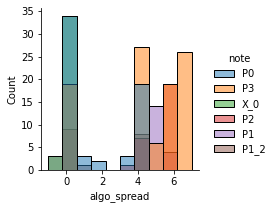

In [784]:
sns.displot(x='algo_spread', data=missed_fills, height=3, hue='note')

In [697]:
missed_buy_fills[missed_buy_fills['algo_spread'] >= 4][miss_cols + ['algo_spread','price_algo_buy','price_algo_sell']]

,note,price_algo,quantity_algo,side_algo,symbol,timestamp,fill_qty,price_mkt,quantity_mkt,bid,ask,bid_sz,ask_sz,mid_price,algo_spread,price_algo_buy,price_algo_sell
5,P2,9997,5,1,PEARLS,3000,0.0,9998.0,1,9996.0,10004.0,1,1,10000.0,5.0,9997.0,10002.0
12,P2,9997,8,1,PEARLS,3600,0.0,9998.0,1,9995.0,10002.0,27,8,9998.5,4.0,9997.0,10001.0
47,P2,9997,18,1,PEARLS,19200,0.0,9998.0,2,9995.0,10002.0,26,1,9998.5,4.0,9997.0,10001.0
71,P2,9998,17,1,PEARLS,27300,0.0,9998.0,6,9995.0,10002.0,25,8,9998.5,4.0,9998.0,10002.0
76,P2,9997,14,1,PEARLS,27700,0.0,9998.0,3,9996.0,10004.0,2,2,10000.0,5.0,9997.0,10002.0
78,P1,9998,14,1,PEARLS,27800,0.0,9998.0,3,9998.0,10004.0,2,2,10001.0,4.0,9998.0,10002.0
99,P2,9998,26,1,PEARLS,31500,0.0,9998.0,1,9996.0,10004.0,1,1,10000.0,5.0,9998.0,10003.0
130,P2,9998,37,1,PEARLS,47300,0.0,9998.0,1,9995.0,10005.0,21,21,10000.0,5.0,9998.0,10003.0
132,P1,9999,37,1,PEARLS,47400,0.0,9998.0,1,9998.0,10005.0,7,22,10001.5,4.0,9999.0,10003.0
142,P2,9998,23,1,PEARLS,51900,0.0,9998.0,1,9996.0,10004.0,2,2,10000.0,5.0,9998.0,10003.0


# Historical Quote Analysis

BANANAS
PEARLS


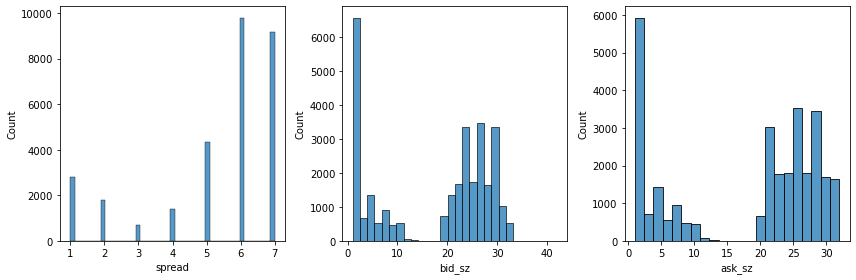

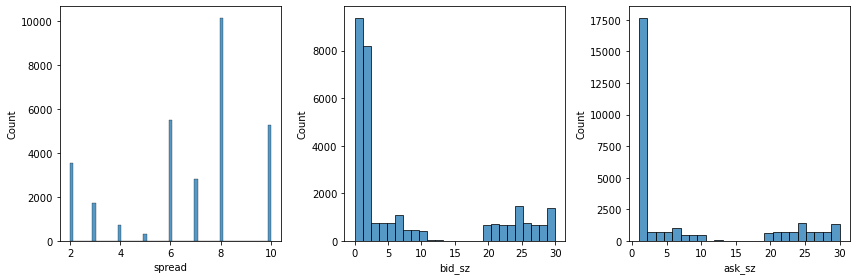

In [772]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(12,4))
    for i, col in enumerate(['spread','bid_sz','ask_sz']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

BANANAS
PEARLS


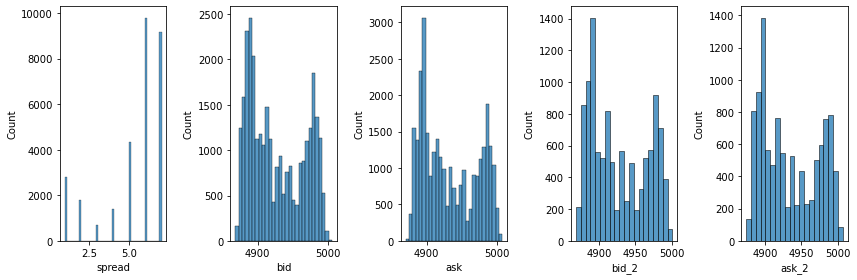

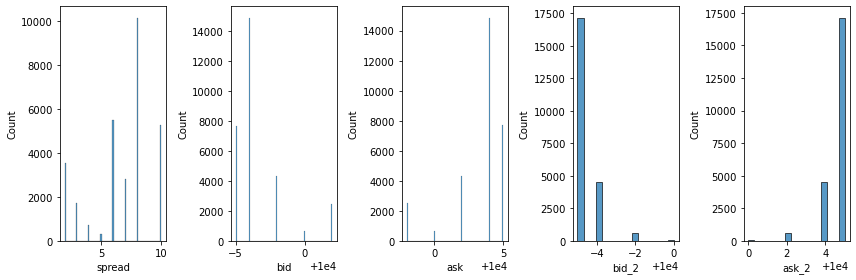

In [773]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(12,4))
    for i, col in enumerate(['spread','bid','ask', 'bid_2','ask_2']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

In [621]:
pearl_trades = hist_trades[p]
pearl_quotes = hist_quotes[p]

b_trades = hist_trades[p]
b_quotes = hist_quotes[p]

In [626]:
b_trades['bid_cross'] = (b_trades['price'] <= b_trades['bid'])
b_trades['ask_cross'] = (b_trades['price'] >= b_trades['ask'])
b_trades['mid_cross'] = np.sign(b_trades['mid_price'] - b_trades['price'])
b_trades['bid_cross_sum'] = b_trades['bid_cross'].cumsum()
b_trades['ask_cross_sum'] = b_trades['ask_cross'].cumsum()
b_trades['mid_cross_sum'] = b_trades['mid_cross'].cumsum()
b_trades['imbalance'] = (b_trades['bid_cross_sum']-b_trades['ask_cross_sum'])

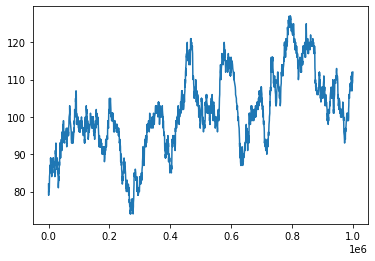

In [641]:
f, ax = plt.subplots()
ax.plot('timestamp','mid_cross_sum', data=b_trades.loc[b_trades['day'] ==0])

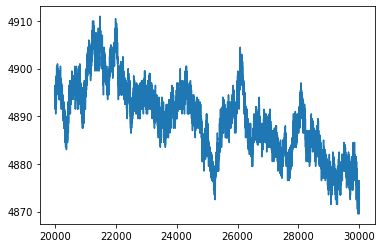

In [640]:
hquote = hist_quotes[b].copy()
hquote['px_diff'] = hquote['mid_price'] - hquote['vwap']

f,ax = plt.subplots()
ax.plot(hquote.loc[hquote['day'] == 0]['mid_price'], label='mid_price')
# ax.plot(hquote['vwap'], label='vwap')

In [479]:
hquote['px_diff'].mean()

0.14181483863124122

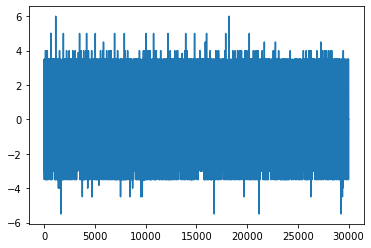

In [478]:
f,ax = plt.subplots()
ax.plot(hquote['px_diff'])

# Historical Trade Analysis

In [472]:
hist_market_trades = hist_trades[b].copy()
quote_levels_feature(hist_market_trades)
hist_market_trades['levels_imb'] = hist_market_trades['bid_levels']-hist_market_trades['ask_levels']
hist_market_trades['spread'] = hist_market_trades['ask']-hist_market_trades['bid']
hist_market_trades['dist_bid_2'] = hist_market_trades['price']-hist_market_trades['bid_2']
hist_market_trades['dist_ask_2'] = hist_market_trades['price']-hist_market_trades['ask_2']

# hist_market_trades_detailed = quote_preprocess(hist_market_trades)

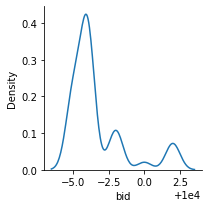

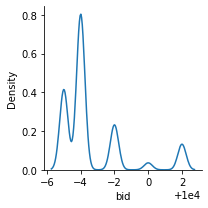

In [126]:
sns.displot(x='bid',data=quote, height=3, kind='kde')
sns.displot(x='bid',data=hist_quotes[p], height=3, kind='kde')
# sns.displot(x='ask',data=quote, height=3)

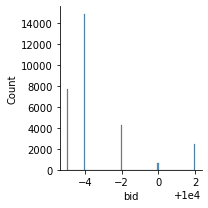

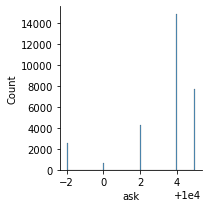

In [123]:
sns.displot(x='ask',data=hist_quotes[p], height=3)

In [108]:
hist_market_trades.columns

Index(['timestamp', 'symbol', 'currency', 'price', 'quantity', 'day', 'bid',
       'bid_sz', 'bid_2', 'bid_sz_2', 'bid_3', 'bid_sz_3', 'ask', 'ask_sz',
       'ask_2', 'ask_sz_2', 'ask_3', 'ask_sz_3', 'mid_price', 'bid_4',
       'bid_sz_4', 'ask_4', 'ask_sz_4', 'bid_5', 'bid_sz_5', 'ask_5',
       'ask_sz_5', 'notional', 'bid_levels', 'ask_levels', 'levels_imb'],
      dtype='object')

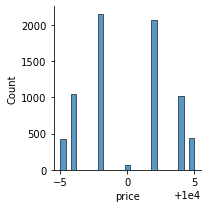

In [109]:
sns.displot(x='price', data=hist_market_trades, height=3)

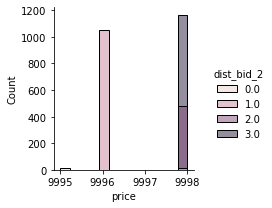

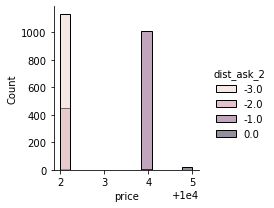

In [117]:
sns.displot(x='price', data=hist_market_trades.loc[hist_market_trades.price < 10000], height=3, hue='dist_bid_2')
sns.displot(x='price', data=hist_market_trades.loc[hist_market_trades.price > 10000], height=3, hue='dist_ask_2')

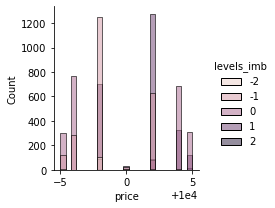

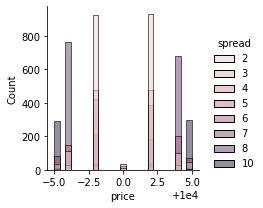

In [114]:
sns.displot(x='price', data=hist_market_trades, height=3, hue='levels_imb')
sns.displot(x='price', data=hist_market_trades, height=3, hue='spread')

# Price Prediction

In [691]:
mid_labels = []
bid_labels = []
ask_labels = []
px_delta_cols = []

for t in FUTURE_TIMES:
    px_delta_cols.append(f'fpx_{t}')
    mid_labels.append(f'fpx_move_{t}')
    bid_labels.append(f'fpx_bid_move_{t}')
    ask_labels.append(f'fpx_ask_move_{t}')

In [692]:
for sym in SYMBOLS:
    sub_data = hist_quotes[sym].copy()
    # sub_data = sub_data.loc[sub_data.volume > 0]
    print("{} {} {} {:.2f}%".format(sym, len(hist_quotes[sym].copy()), len(sub_data), 100*len(sub_data)/len(quote)))
    corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_v1', 'fair_v1_move_1', 'bid_move_1','ask_move_1'] + mid_labels].corr()
    display(corr.style.background_gradient(cmap='coolwarm').format(precision=3))

BANANAS 30000 30000 3003.00%


,quote_imb,levels_imb,dist_fair_v1,fair_v1_move_1,bid_move_1,ask_move_1,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50,fpx_move_100
quote_imb,1.000,-0.906,0.735,0.210,-0.327,-0.339,0.395,0.333,0.295,0.225,0.184,0.142
levels_imb,-0.906,1.000,-0.821,-0.210,0.369,0.392,-0.453,-0.382,-0.340,-0.259,-0.211,-0.162
dist_fair_v1,0.735,-0.821,1.000,0.077,-0.525,-0.504,0.525,0.466,0.426,0.342,0.281,0.216
fair_v1_move_1,0.210,-0.210,0.077,1.000,0.171,0.202,-0.008,-0.014,-0.021,-0.025,-0.019,-0.013
bid_move_1,-0.327,0.369,-0.525,0.171,1.000,0.214,-0.276,-0.248,-0.234,-0.188,-0.153,-0.116
ask_move_1,-0.339,0.392,-0.504,0.202,0.214,1.000,-0.290,-0.255,-0.238,-0.195,-0.156,-0.121
fpx_move_1,0.395,-0.453,0.525,-0.008,-0.276,-0.290,1.000,0.364,0.309,0.231,0.187,0.145
fpx_move_5,0.333,-0.382,0.466,-0.014,-0.248,-0.255,0.364,1.000,0.445,0.327,0.257,0.197
fpx_move_10,0.295,-0.340,0.426,-0.021,-0.234,-0.238,0.309,0.445,1.000,0.416,0.315,0.236
fpx_move_25,0.225,-0.259,0.342,-0.025,-0.188,-0.195,0.231,0.327,0.416,1.000,0.469,0.344


PEARLS 30000 30000 3003.00%


,quote_imb,levels_imb,dist_fair_v1,fair_v1_move_1,bid_move_1,ask_move_1,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50,fpx_move_100
quote_imb,1.000,-0.087,0.255,-0.002,-0.132,-0.132,0.087,0.105,0.099,0.097,0.097,0.096
levels_imb,-0.087,1.000,-0.882,0.094,0.495,0.487,-0.620,-0.614,-0.618,-0.625,-0.625,-0.619
dist_fair_v1,0.255,-0.882,1.000,0.071,-0.505,-0.499,0.582,0.582,0.581,0.587,0.586,0.582
fair_v1_move_1,-0.002,0.094,0.071,1.000,0.216,0.217,-0.093,-0.087,-0.090,-0.088,-0.093,-0.096
bid_move_1,-0.132,0.495,-0.505,0.216,1.000,0.186,-0.342,-0.341,-0.335,-0.331,-0.343,-0.330
ask_move_1,-0.132,0.487,-0.499,0.217,0.186,1.000,-0.322,-0.325,-0.326,-0.329,-0.330,-0.335
fpx_move_1,0.087,-0.620,0.582,-0.093,-0.342,-0.322,1.000,0.406,0.406,0.407,0.410,0.401
fpx_move_5,0.105,-0.614,0.582,-0.087,-0.341,-0.325,0.406,1.000,0.402,0.410,0.400,0.402
fpx_move_10,0.099,-0.618,0.581,-0.090,-0.335,-0.326,0.406,0.402,1.000,0.403,0.404,0.404
fpx_move_25,0.097,-0.625,0.587,-0.088,-0.331,-0.329,0.407,0.410,0.403,1.000,0.419,0.414


In [187]:
from sklearn.linear_model import LogisticRegression

In [693]:
for sym in SYMBOLS:
    print(sym)
    data = hist_quotes[sym].copy()
    features = ['dist_fair_v1', 'bid_move_1','ask_move_1']

    labels = mid_labels
    total_samples = len(data)
    train_samples = total_samples//2

    train_data = data.iloc[:train_samples][features+labels]
    X_train = train_data[features].values
    clfs = {}

    for t in FUTURE_TIMES:
        y_train = train_data[f'fpx_move_{t}'].values
        clfs[t] = LogisticRegression(random_state=0, penalty='none').fit(X_train, y_train)

    for t in FUTURE_TIMES:
        probs = clfs[t].predict_proba(X_train)
        train_data[f'predict_{t}'] = clfs[t].classes_[probs.argmax(axis=1)]
        train_data[f'predict_prob_{t}'] = probs.max(axis=1)
        train_data[f'correct_{t}'] = train_data[f'predict_{t}'] == train_data[f'fpx_move_{t}']
        print('{} {:.3}'.format(t, train_data[f'correct_{t}'].mean()))

BANANAS
1 0.58
5 0.588
10 0.585
25 0.575
50 0.569
100 0.575
PEARLS
1 0.64
5 0.64
10 0.642
25 0.645
50 0.643
100 0.644


# Bananas Price Prediction by Trade Price

In [619]:
sym = b
quote = dfs['order_depths'][sym]

In [620]:
quote

,timestamp,symbol,bid_levels,bid,bid_sz,bid_2,bid_sz_2,bid_5,bid_sz_5,bid_4,...,ask_4,ask_sz_4,ask_3,ask_sz_3,ask_2,ask_sz_2,mid_price,volume,vwap,trades
0,0,BANANAS,2,4893.0,9,4892.0,23.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4896.0,0.0,4896.0,0.0
1,100,BANANAS,2,4897.0,1,4892.0,26.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4897.5,0.0,4897.5,0.0
2,200,BANANAS,1,4892.0,22,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4895.5,0.0,4895.5,0.0
3,300,BANANAS,2,4898.0,1,4893.0,26.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4899.0,0.0,4899.0,0.0
4,400,BANANAS,2,4894.0,8,4893.0,28.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4899.0,28.0,4895.0,0.0,4895.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,99500,BANANAS,1,4889.0,20,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4892.5,0.0,4892.5,0.0
995,99600,BANANAS,1,4889.0,28,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4896.0,28.0,4890.5,9.0,4895.0,1.0
996,99700,BANANAS,2,4892.0,2,4889.0,26.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4894.0,0.0,4894.0,0.0
997,99800,BANANAS,1,4890.0,26,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4897.0,25.0,4896.0,1.0,4892.5,2.0,4892.0,1.0


In [585]:
sym = b
quote = dfs['quote'][sym]
market_trades = pd.concat([dfs['market_trades'][sym], dfs['own_trades'][sym]])
market_trades.sort_values(['symbol','timestamp'], inplace=True)
market_trades.reset_index(drop=True, inplace=True)

market_trades['bid_cross'] = (market_trades['price'] <= market_trades['bid'])*market_trades['quantity']
market_trades['ask_cross'] = (market_trades['price'] >= market_trades['ask'])*market_trades['quantity']
market_trades['mid_cross'] = np.sign(market_trades['mid_price']-market_trades['price'])*market_trades['quantity']
market_trades['bid_cross_sum'] = market_trades['bid_cross'].cumsum()
market_trades['ask_cross_sum'] = market_trades['ask_cross'].cumsum()
market_trades['imbalance'] =  market_trades['bid_cross_sum']-market_trades['ask_cross_sum']
market_trades['mid_cross_sum'] = market_trades['mid_cross'].cumsum()

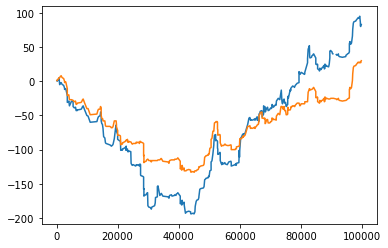

In [588]:
f, ax = plt.subplots()

ax.plot('timestamp', 'mid_cross_sum', data=market_trades)
ax.plot('timestamp', 'imbalance', data=market_trades)

<AxesSubplot:>

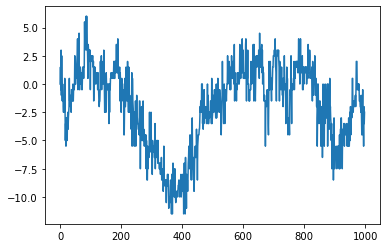

In [587]:
(quote['mid_price']-quote['mid_price'].iloc[0]).plot()